In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score

from skimage import exposure, util
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening, binary_closing, square
import scipy.io as sio

In [2]:
data_path = "./glaucoma-detection/"
meta_path = os.path.join(data_path, "glaucoma.csv")
imgs_path = os.path.join(data_path, "ORIGA/ORIGA/Images/")
img_path = os.path.join(imgs_path, "*.jpg")
wkg_path = os.path.join(data_path, "working/")
save_path = os.path.join(wkg_path, "seg_images/")
os.makedirs(save_path, exist_ok=True)
ptmd_path = os.path.join(wkg_path, "pretrained_models/")
os.makedirs(ptmd_path, exist_ok=True)
rslt_path = os.path.join(data_path, "results_noSg/")
os.makedirs(rslt_path, exist_ok=True)

In [3]:
meta = pd.read_csv(meta_path)
# meta

In [4]:
all_images = glob(img_path)
# all_images=glob(os.path.join(save_path, "*.jpg"))
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(imgs_path, fn))
meta["SegPath"] = meta["Filename"].apply(lambda fn: os.path.join(save_path, fn))
# meta.head()

In [5]:
# meta["Glaucoma"].value_counts()

In [6]:
# meta.groupby("Glaucoma")["ExpCDR"].mean()

In [7]:
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()
## reason?

### Divide train and test datasets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 7) (85, 7)


### Load datasets

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [11]:
class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()

    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            path = Path(row["Path"])
            data.append(((path, exp_cdr), label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [13]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

### Build model: EfficientNet and MobileNet

In [14]:
from torchvision import models
import torchvision.models as models
import timm

In [15]:
# 1. Use EfficientNet
class EfficientModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # load from local path due to huggingface connection problems
        mdpath = os.path.join(ptmd_path, "efficientnet_b3.pytorch_model.bin")
        state_dict = torch.load(mdpath, map_location=torch.device('cpu'))
        self.cnn_model = timm.create_model("efficientnet_b3", pretrained=False)
        
        self.cnn_model.load_state_dict(state_dict)
        self.cnn_model.reset_classifier(num_classes=0) 
        
        # Or download from huggingface directly
        # self.cnn_model = timm.create_model('efficientnet_b3',  pretrained=True, num_classes=0)
        # num_classes=0 will remove the final classification layer, directly returning features

        num_features = self.cnn_model.num_features

        # Reduce high-dimensional EfficientNet to 30D to match previous design
        # Add ReLU and Dropout to increase nonlinearity and prevent overfitting
        self.cnn_projection = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x = self.final_layers(x1)
        return x

In [16]:
effmodel = EfficientModel()
effmodel = effmodel.to("cuda:0")

In [17]:
# 2. Use MobileNet
class MobileModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        mdpath = os.path.join(ptmd_path, "mobilenet_v3_large.pytorch_model.bin")
        state_dict = torch.load(mdpath, map_location=torch.device('cpu'))
        self.cnn_model = timm.create_model("mobilenetv3_large_100", pretrained=False)
        
        self.cnn_model.load_state_dict(state_dict)
        self.cnn_model.reset_classifier(num_classes=0) 

        # # the real feature does not equal num_features in mbnet
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            out = self.cnn_model(dummy)
            real_features = out.shape[1]

        self.cnn_projection = nn.Sequential(
            nn.Linear(real_features, 512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)
        )

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(30, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x = self.final_layers(x1)
        return x

In [18]:
mobmodel = MobileModel()
mobmodel = mobmodel.to("cuda:0")

### Fine tuning

In [19]:
from fastai.vision.all import *
# Load LabelSmoothingCrossEntropy which performs better in medical images than cross entropy
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

In [20]:
def ft_train(model, name):
    # Define learner
    learner = Learner(DataLoaders(train_loader, test_loader), model, path=rslt_path,
                      metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                      loss_func=LabelSmoothingCrossEntropy())

    # Define callback function
    save_best = SaveModelCallback(monitor='f1_score', fname=f'ft_{name}_for_glaucoma_detection')

    early_stop = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    print("Start fine tunning")

    learner.fine_tune(epochs=50, base_lr=1e-3, freeze_epochs=3, cbs=[early_stop, save_best])
    
    MODEL_FNAME = f'ft_{name}_for_glaucoma_detection'
    
    learner.load(MODEL_FNAME)

    print(f"Successfully load the best weights：{learner.path}/models/{MODEL_FNAME}.pth")

    # Evaluat using learner.validate()
    results = learner.validate()

    print("\n--- Validation（Test Loader）Evaluation ---")
    print(f"Valid Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Recall: {results[2]:.4f}")
    print(f"Precision: {results[3]:.4f}")
    print(f"F1 Score: {results[4]:.4f}")
    print(f"ROC-AUC: {results[5]:.4f}")

In [21]:
%%time
ft_train(effmodel, "efficientnet")

Start fine tunning


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.718170,0.687732,0.552941,0.000000,0.000000,0.000000,0.702128,00:19
1,0.664847,0.611846,0.752941,0.710526,0.729730,0.720000,0.772676,00:19
2,0.597653,0.726259,0.635294,0.578947,0.594595,0.586667,0.719485,00:18


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.7200000000000001.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.471102,0.575978,0.694118,0.789474,0.625000,0.697674,0.817469,00:18
1,0.431095,0.643254,0.658824,0.789474,0.588235,0.674157,0.792273,00:18
2,0.397851,0.676429,0.694118,0.815789,0.620000,0.704545,0.763718,00:18
3,0.366100,0.629241,0.694118,0.789474,0.625000,0.697674,0.785554,00:18
4,0.332162,0.690785,0.658824,0.736842,0.595745,0.658824,0.761478,00:18
5,0.309259,0.768605,0.670588,0.710526,0.613636,0.658537,0.758679,00:18
6,0.302893,0.663639,0.764706,0.605263,0.821429,0.696970,0.790034,00:18
7,0.307293,0.684141,0.705882,0.842105,0.627451,0.719101,0.778275,00:18
8,0.317165,0.726266,0.682353,0.789474,0.612245,0.689655,0.781635,00:19
9,0.333849,0.588568,0.764706,0.736842,0.736842,0.736842,0.801232,00:18


Better model found at epoch 0 with f1_score value: 0.6976744186046512.
Better model found at epoch 2 with f1_score value: 0.7045454545454546.
Better model found at epoch 7 with f1_score value: 0.7191011235955056.
Better model found at epoch 9 with f1_score value: 0.7368421052631579.
Better model found at epoch 23 with f1_score value: 0.7435897435897436.
Better model found at epoch 34 with f1_score value: 0.7631578947368421.
Better model found at epoch 44 with f1_score value: 0.7792207792207793.
Successfully load the best weights：glaucoma-detection/results_noSg/models/ft_efficientnet_for_glaucoma_detection.pth



--- Validation（Test Loader）Evaluation ---
Valid Loss: 0.6046
Accuracy: 0.8000
Recall: 0.7895
Precision: 0.7692
F1 Score: 0.7792
ROC-AUC: 0.8236
CPU times: user 22min 19s, sys: 22.4 s, total: 22min 42s
Wall time: 16min 53s


In [22]:
%%time
ft_train(mobmodel, "mobilenet")

Start fine tunning


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.690570,0.680574,0.658824,0.342105,0.764706,0.472727,0.732923,00:18
1,0.660794,0.671525,0.752941,0.657895,0.757576,0.704225,0.783875,00:18
2,0.626409,0.834232,0.447059,1.000000,0.447059,0.617886,0.757559,00:17


Better model found at epoch 0 with f1_score value: 0.4727272727272727.
Better model found at epoch 1 with f1_score value: 0.704225352112676.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.546490,0.609867,0.705882,0.736842,0.651163,0.691358,0.800112,00:17
1,0.509086,0.590022,0.741176,0.842105,0.666667,0.744186,0.811870,00:17
2,0.466869,0.594099,0.752941,0.684211,0.742857,0.712329,0.812990,00:16
3,0.421931,0.604597,0.694118,0.763158,0.630435,0.690476,0.810190,00:17
4,0.368646,0.617401,0.729412,0.789474,0.666667,0.722892,0.818029,00:17
5,0.330029,0.868879,0.670588,0.947368,0.580645,0.720000,0.807391,00:17
6,0.303845,0.757364,0.670588,0.710526,0.613636,0.658537,0.777156,00:17
7,0.290576,0.838839,0.658824,0.815789,0.584906,0.681319,0.766517,00:16
8,0.291334,0.834871,0.611765,0.815789,0.543860,0.652632,0.744681,00:17
9,0.298831,0.726652,0.717647,0.763158,0.659091,0.707317,0.755319,00:17


Better model found at epoch 0 with f1_score value: 0.6913580246913581.
Better model found at epoch 1 with f1_score value: 0.744186046511628.
No improvement since epoch 1: early stopping
Successfully load the best weights：glaucoma-detection/results_noSg/models/ft_mobilenet_for_glaucoma_detection.pth



--- Validation（Test Loader）Evaluation ---
Valid Loss: 0.5900
Accuracy: 0.7412
Recall: 0.8421
Precision: 0.6667
F1 Score: 0.7442
ROC-AUC: 0.8119
CPU times: user 8min 4s, sys: 3.9 s, total: 8min 8s
Wall time: 5min 54s


### Evaluation and visualization

In [23]:
def plot_training_history(learner,fold, ptmodel, title="Training History"):
    """
    Extract data from FastAI Learner and plot Loss and Metrics curves.
    """
    values = np.array(learner.recorder.values)
    metric_names = learner.recorder.metric_names

    # FastAI's metric_names used to be ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'f1_score', 'roc_auc_binary', ...]
    # Automatically find
    try:
        idx_train_loss = metric_names.index('train_loss') - 1
        idx_valid_loss = metric_names.index('valid_loss') - 1
        idx_f1 = metric_names.index('f1_score') - 1
        idx_auc = metric_names.index('roc_auc_score') - 1
    except ValueError:
        print("Error: Cannot find the index, please check: learner.recorder.metric_names")
        print("Current available indeces:", metric_names)
        return

    train_losses = values[:, idx_train_loss]
    valid_losses = values[:, idx_valid_loss]
    f1_scores = values[:, idx_f1]
    auc_scores = values[:, idx_auc]
    epochs = range(1, len(train_losses) + 1)

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Loss
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, valid_losses, 'r--', label='Valid Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Mark the lowest loss point
    min_loss_idx = np.argmin(valid_losses)
    ax1.scatter(epochs[min_loss_idx], valid_losses[min_loss_idx], s=100, c='red', marker='*')

    # Metrics (F1 & AUC)
    ax2.plot(epochs, f1_scores, 'g-', label='F1 Score', linewidth=2, marker='.')
    ax2.plot(epochs, auc_scores, 'purple', label='ROC-AUC', linewidth=2, linestyle='--', marker='.')

    ax2.set_title(f'{title} - Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('F1_Score', fontsize=12)
    ax2.set_ylim(0, 1.05) 
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Mark the best F1 point
    max_f1_idx = np.argmax(f1_scores)
    ax2.scatter(epochs[max_f1_idx], f1_scores[max_f1_idx], s=100, c='green', marker='*')
    SAVE_FILENAME = os.path.join(rslt_path, f'{ptmodel}_KFold_Training_Curves_{fold+1}.png')
    plt.savefig(SAVE_FILENAME, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

### K-Fold

In [24]:
from sklearn.model_selection import KFold, StratifiedKFold

In [25]:
OUTPUT_DIR = Path(rslt_path)

df = new_meta

N_SPLITS = 5 
RANDOM_STATE = 42

kf = StratifiedKFold(n_splits=N_SPLITS, 
                     shuffle=True, 
                     random_state=RANDOM_STATE) # Ensure similar label proportion of each fold


--- Pretrained Model: EfficientNet_b3 ---

--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.692044,0.699337,0.485294,0.000000,0.000000,0.000000,0.530277,00:20
1,0.629336,0.789898,0.514706,0.088235,0.600000,0.153846,0.508651,00:20
2,0.610609,1.265394,0.544118,1.000000,0.523077,0.686869,0.521626,00:20


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.15384615384615385.
Better model found at epoch 2 with f1_score value: 0.686868686868687.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.418565,0.944828,0.573529,0.470588,0.592593,0.524590,0.628893,00:20
1,0.377357,0.775344,0.573529,0.676471,0.560976,0.613333,0.671280,00:20
2,0.351538,0.941231,0.544118,0.588235,0.540541,0.563380,0.604671,00:20
3,0.345701,0.990810,0.632353,0.470588,0.695652,0.561404,0.658304,00:20
4,0.359978,0.778392,0.573529,0.470588,0.592593,0.524590,0.651384,00:20
5,0.341335,0.851870,0.558824,0.705882,0.545455,0.615385,0.694637,00:20
6,0.314887,0.794403,0.676471,0.705882,0.666667,0.685714,0.718858,00:20
7,0.295170,0.825048,0.632353,0.588235,0.645161,0.615385,0.697232,00:20
8,0.281869,0.834229,0.647059,0.617647,0.656250,0.636364,0.703287,00:20
9,0.264470,0.829067,0.661765,0.676471,0.657143,0.666667,0.702422,00:19


Better model found at epoch 0 with f1_score value: 0.5245901639344261.
Better model found at epoch 1 with f1_score value: 0.6133333333333334.
Better model found at epoch 5 with f1_score value: 0.6153846153846153.
Better model found at epoch 6 with f1_score value: 0.6857142857142857.


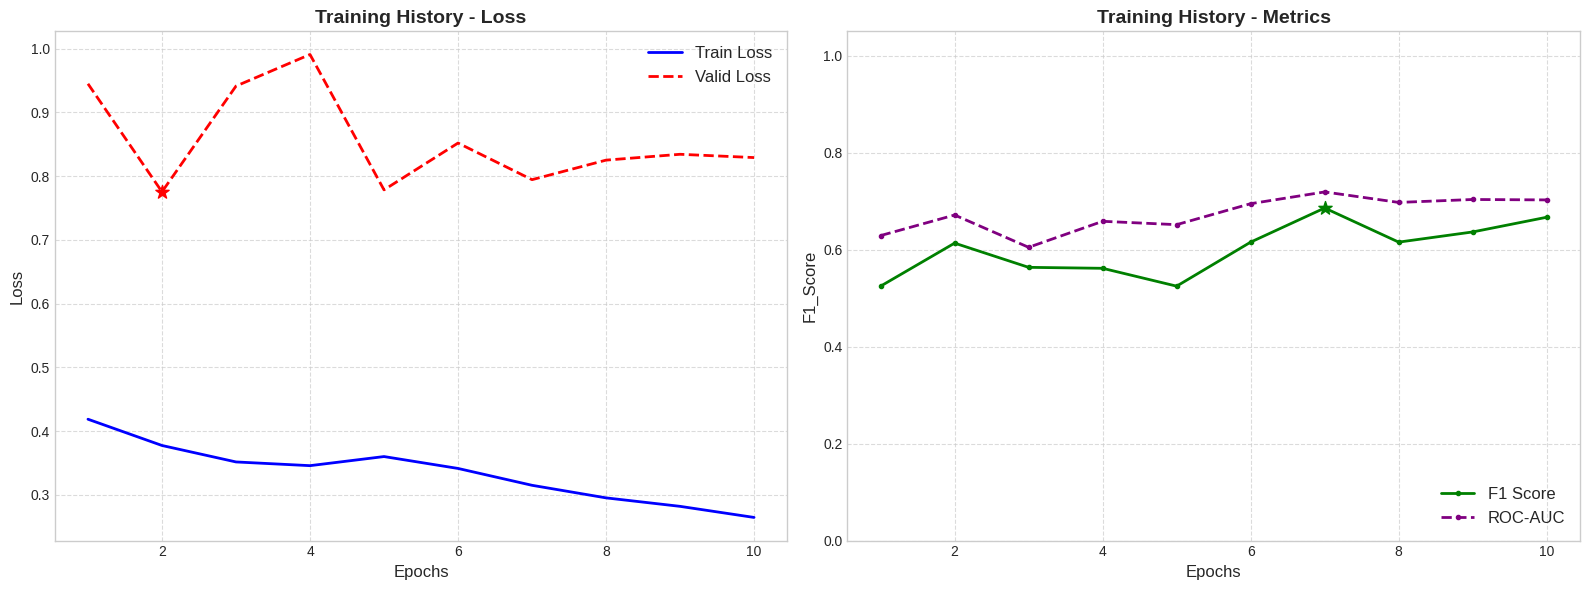

✅ Fold 1 Completed. F1 Score: 0.6857, AUC: 0.7189

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.696380,0.684810,0.514706,0.029412,1.000000,0.057143,0.724048,00:20
1,0.638767,0.665817,0.647059,0.500000,0.708333,0.586207,0.735294,00:19
2,0.611822,1.010914,0.558824,0.911765,0.534483,0.673913,0.734429,00:20


Better model found at epoch 0 with f1_score value: 0.05714285714285715.
Better model found at epoch 1 with f1_score value: 0.5862068965517241.
Better model found at epoch 2 with f1_score value: 0.6739130434782609.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.495592,0.674558,0.735294,0.647059,0.785714,0.709677,0.739619,00:20
1,0.428223,0.812436,0.705882,0.617647,0.750000,0.677419,0.746540,00:20
2,0.395735,0.586864,0.764706,0.764706,0.764706,0.764706,0.826990,00:20
3,0.364399,0.809139,0.705882,0.529412,0.818182,0.642857,0.748270,00:20
4,0.348752,0.817478,0.691176,0.588235,0.740741,0.655738,0.727509,00:19
5,0.340780,0.794100,0.705882,0.529412,0.818182,0.642857,0.743945,00:20
6,0.313376,0.863057,0.676471,0.500000,0.772727,0.607143,0.740484,00:20
7,0.294599,0.696446,0.750000,0.647059,0.814815,0.721311,0.786332,00:20
8,0.283861,0.733611,0.764706,0.676471,0.821429,0.741935,0.760381,00:20
9,0.269268,0.744375,0.764706,0.676471,0.821429,0.741935,0.751730,00:20


Better model found at epoch 0 with f1_score value: 0.7096774193548386.
Better model found at epoch 2 with f1_score value: 0.7647058823529412.


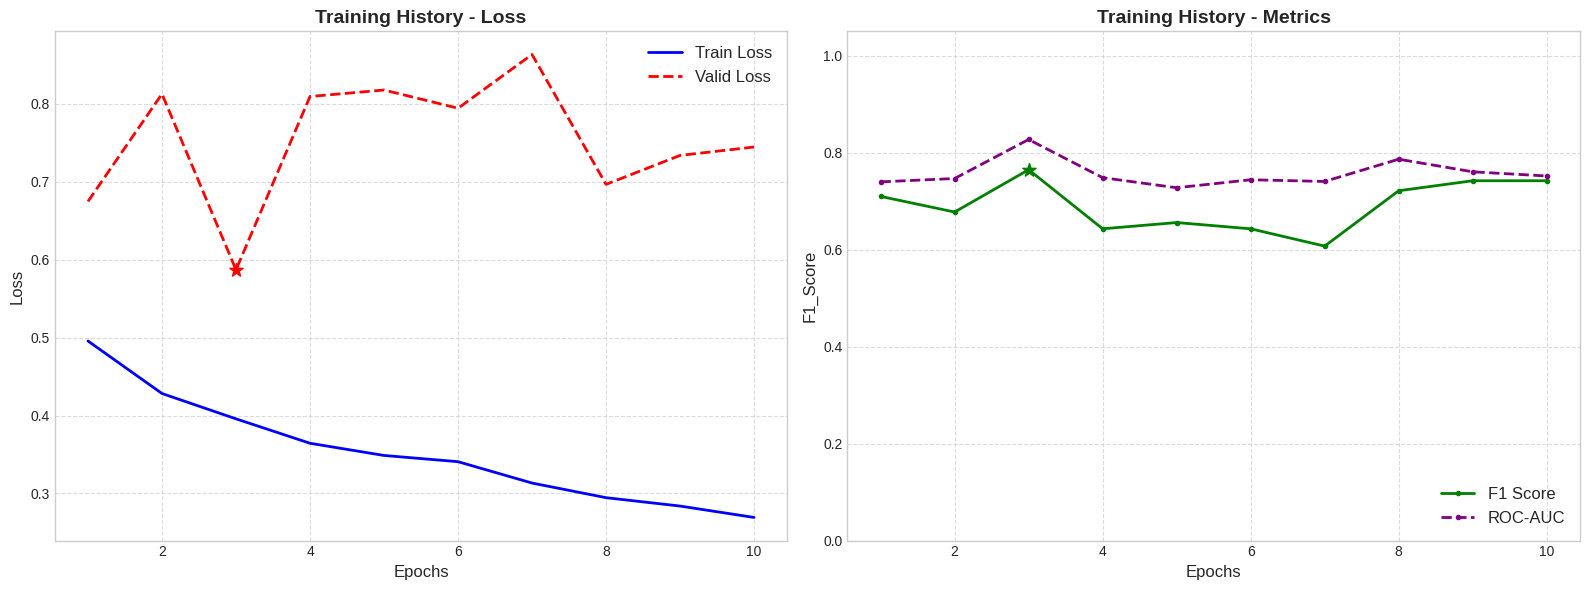

✅ Fold 2 Completed. F1 Score: 0.7647, AUC: 0.8270

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.685578,0.654167,0.750000,0.500000,1.000000,0.666667,0.897924,00:20
1,0.622921,0.726840,0.602941,0.382353,0.684211,0.490566,0.672145,00:19
2,0.634051,0.614539,0.661765,0.823529,0.622222,0.708861,0.805363,00:20


Better model found at epoch 0 with f1_score value: 0.6666666666666666.
Better model found at epoch 2 with f1_score value: 0.7088607594936709.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.501397,0.510979,0.852941,0.735294,0.961538,0.833333,0.888408,00:19
1,0.415113,0.652172,0.808824,0.764706,0.838710,0.800000,0.813149,00:20
2,0.424327,0.447654,0.838235,0.764706,0.896552,0.825397,0.924740,00:19
3,0.397507,0.546377,0.823529,0.735294,0.892857,0.806452,0.869377,00:19
4,0.370913,0.716593,0.705882,0.647059,0.733333,0.687500,0.778547,00:20
5,0.361583,0.587730,0.779412,0.794118,0.771429,0.782609,0.844291,00:20
6,0.333287,0.647069,0.735294,0.823529,0.700000,0.756757,0.865917,00:20
7,0.307274,0.685666,0.735294,0.705882,0.750000,0.727273,0.778547,00:20
8,0.284201,0.665040,0.735294,0.647059,0.785714,0.709677,0.827855,00:19
9,0.275860,0.648321,0.779412,0.735294,0.806452,0.769231,0.829585,00:20


Better model found at epoch 0 with f1_score value: 0.8333333333333333.


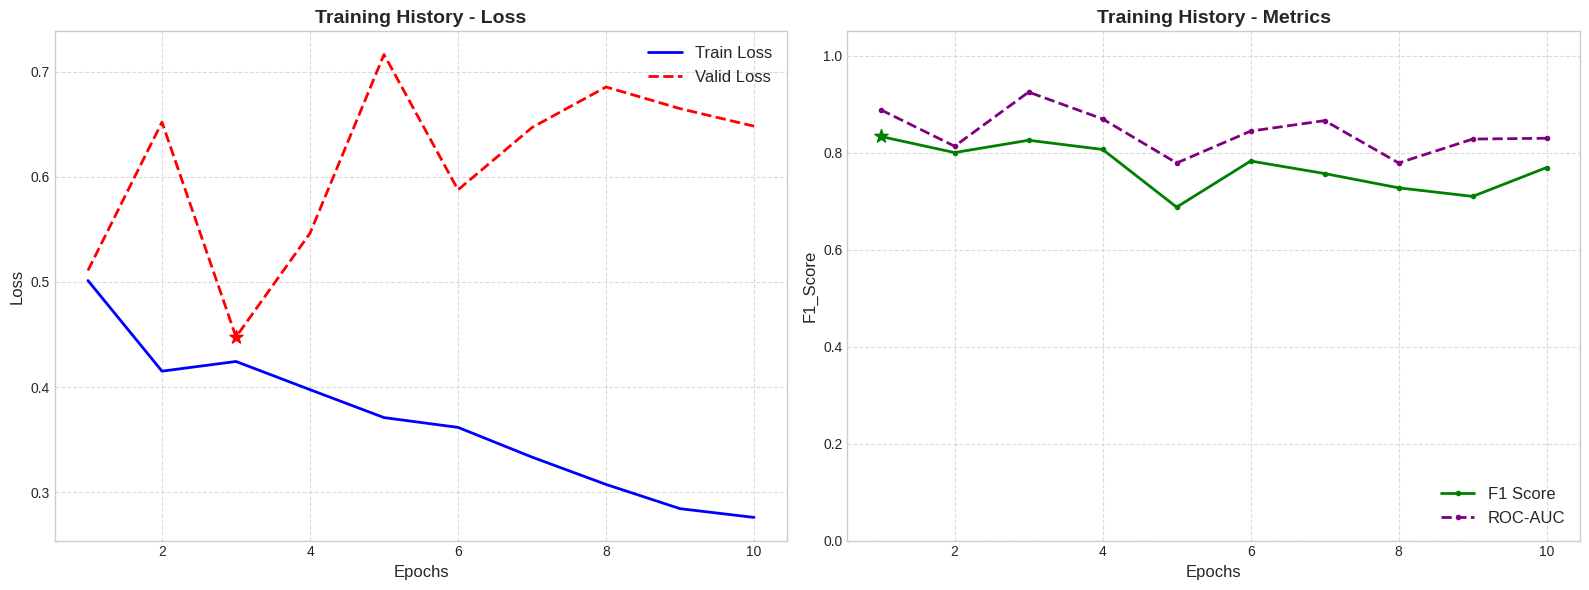

✅ Fold 3 Completed. F1 Score: 0.8333, AUC: 0.8884

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.687202,0.674627,0.686567,0.606061,0.714286,0.655738,0.804813,00:20
1,0.668731,0.665383,0.656716,0.515152,0.708333,0.596491,0.661319,00:20
2,0.627828,0.516890,0.746269,0.848485,0.700000,0.767123,0.873440,00:19


Better model found at epoch 0 with f1_score value: 0.6557377049180327.
Better model found at epoch 2 with f1_score value: 0.7671232876712328.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.455411,0.531815,0.776119,0.787879,0.764706,0.776119,0.878788,00:19
1,0.379654,0.586708,0.835821,0.818182,0.843750,0.830769,0.847594,00:20
2,0.365583,0.776388,0.776119,0.909091,0.714286,0.800000,0.812834,00:20
3,0.381966,0.713924,0.686567,0.545455,0.750000,0.631579,0.800357,00:20
4,0.361698,0.665591,0.761194,0.696970,0.793103,0.741935,0.870766,00:20
5,0.338966,0.602080,0.791045,0.727273,0.827586,0.774194,0.869875,00:20
6,0.319128,0.541192,0.791045,0.818182,0.771429,0.794118,0.897504,00:20
7,0.304443,0.520505,0.805970,0.818182,0.794118,0.805970,0.908200,00:20
8,0.289511,0.525358,0.850746,0.787879,0.896552,0.838710,0.904635,00:20
9,0.274563,0.517937,0.835821,0.787879,0.866667,0.825397,0.908200,00:20


Better model found at epoch 0 with f1_score value: 0.7761194029850745.
Better model found at epoch 1 with f1_score value: 0.8307692307692308.
Better model found at epoch 8 with f1_score value: 0.8387096774193549.


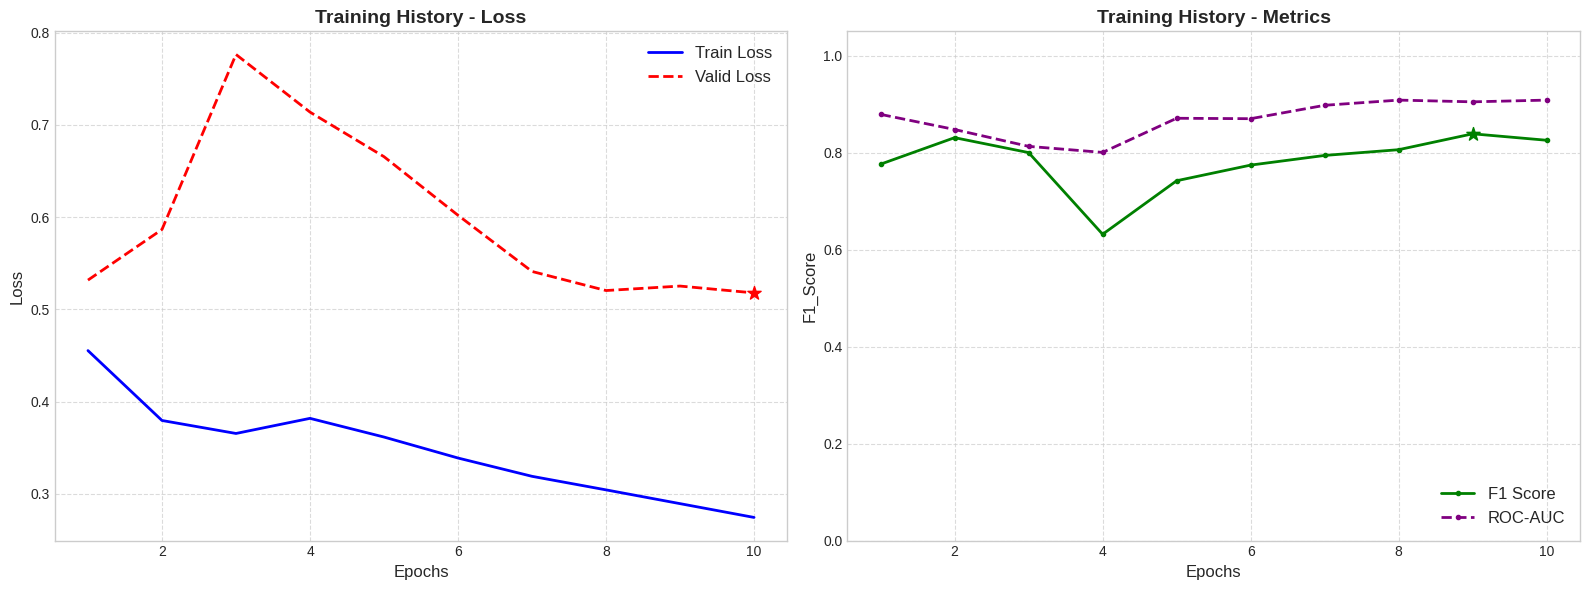

✅ Fold 4 Completed. F1 Score: 0.8387, AUC: 0.9046

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.691058,0.657747,0.731343,0.818182,0.692308,0.750000,0.839572,00:19
1,0.643865,0.650234,0.626866,0.787879,0.590909,0.675325,0.796791,00:19
2,0.615127,0.902412,0.805970,0.727273,0.857143,0.786885,0.861854,00:19


Better model found at epoch 0 with f1_score value: 0.7500000000000001.
Better model found at epoch 2 with f1_score value: 0.7868852459016394.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.396311,0.536289,0.820895,0.727273,0.888889,0.800000,0.868984,00:19
1,0.367836,0.572930,0.835821,0.787879,0.866667,0.825397,0.818182,00:20
2,0.362627,0.594635,0.805970,0.727273,0.857143,0.786885,0.853832,00:20
3,0.362953,0.579991,0.791045,0.909091,0.731707,0.810811,0.874332,00:19
4,0.337314,0.635607,0.776119,0.878788,0.725000,0.794521,0.843137,00:19
5,0.317471,0.816927,0.656716,0.909091,0.600000,0.722892,0.887701,00:19
6,0.311943,0.499405,0.865672,0.727273,1.000000,0.842105,0.893939,00:19
7,0.297537,0.521068,0.835821,0.848485,0.823529,0.835821,0.892157,00:19
8,0.281563,0.569394,0.776119,0.878788,0.725000,0.794521,0.893939,00:19
9,0.264454,0.522831,0.791045,0.848485,0.756757,0.800000,0.895722,00:19


Better model found at epoch 0 with f1_score value: 0.7999999999999999.
Better model found at epoch 1 with f1_score value: 0.8253968253968254.
Better model found at epoch 6 with f1_score value: 0.8421052631578948.


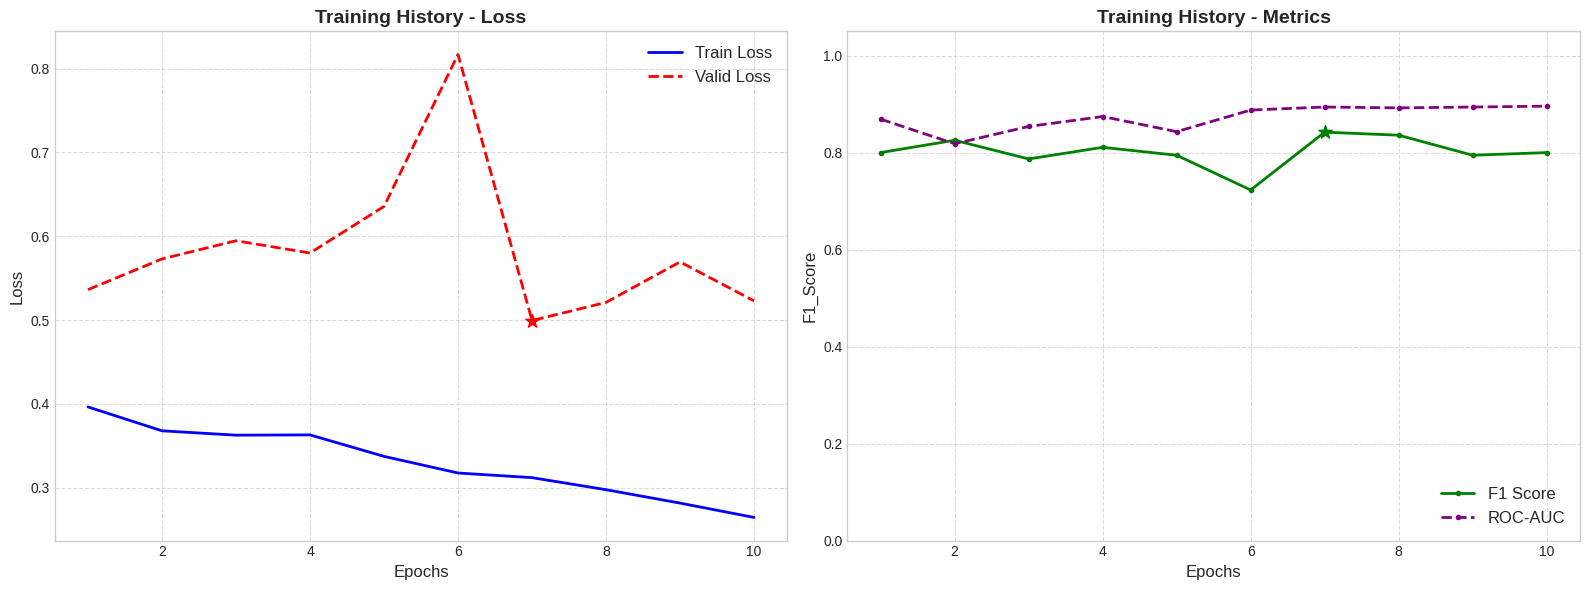

✅ Fold 5 Completed. F1 Score: 0.8421, AUC: 0.8939

--- K-Fold Evaluation ---
   Fold        F1       AUC
0     1  0.685714  0.718858
1     2  0.764706  0.826990
2     3  0.833333  0.888408
3     4  0.838710  0.904635
4     5  0.842105  0.893939
------------------------
Average F1 Score: 0.7929 ± 0.0679
Average AUC Score: 0.8466 ± 0.0776


In [26]:
print(f"\n--- Pretrained Model: EfficientNet_b3 ---")

all_fold_metrics_eff = []
# Main loop
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)

    # Intialize the model
    torch.cuda.empty_cache()
    effmodel = EfficientModel()
    effmodel = effmodel.to("cuda:0")
    
    learner = Learner(dls, effmodel, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'fold_{fold+1}_bst_efficientnet', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    # Train and save the best model
    learner.fine_tune(
        epochs=10,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold,"EfficientNet_b3")

    # Validate and record results
    learner.load(f'fold_{fold+1}_bst_efficientnet') 
    metrics = learner.validate()

    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics_eff.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")

final_results_df = pd.DataFrame(all_fold_metrics_eff)
print("\n--- K-Fold Evaluation ---")
print(final_results_df)
print("------------------------")
print(f"Average F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"Average AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")


--- Pretrained Model: MobileNet_v3 ---

--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.675923,0.687501,0.573529,0.441176,0.600000,0.508475,0.564014,00:18
1,0.600615,0.712660,0.573529,0.823529,0.549020,0.658824,0.667820,00:18
2,0.561383,0.765160,0.573529,0.823529,0.549020,0.658824,0.618512,00:18


Better model found at epoch 0 with f1_score value: 0.5084745762711865.
Better model found at epoch 1 with f1_score value: 0.6588235294117647.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.397932,1.042842,0.588235,0.470588,0.615385,0.533333,0.608131,00:18
1,0.352231,1.012412,0.558824,0.529412,0.562500,0.545455,0.591696,00:18
2,0.337658,0.985876,0.588235,0.470588,0.615385,0.533333,0.576125,00:18
3,0.334995,0.977419,0.558824,0.500000,0.566667,0.531250,0.578720,00:18
4,0.317328,1.113602,0.558824,0.911765,0.534483,0.673913,0.647059,00:18
5,0.301134,1.101718,0.529412,0.558824,0.527778,0.542857,0.573529,00:19
6,0.307617,1.149756,0.617647,0.882353,0.576923,0.697674,0.570069,00:18
7,0.299554,0.988090,0.647059,0.852941,0.604167,0.707317,0.590830,00:18
8,0.284800,0.935177,0.602941,0.676471,0.589744,0.630137,0.632353,00:19
9,0.271574,0.929446,0.558824,0.588235,0.555556,0.571429,0.639273,00:18


Better model found at epoch 0 with f1_score value: 0.5333333333333333.
Better model found at epoch 1 with f1_score value: 0.5454545454545455.
Better model found at epoch 4 with f1_score value: 0.6739130434782609.
Better model found at epoch 6 with f1_score value: 0.6976744186046512.
Better model found at epoch 7 with f1_score value: 0.7073170731707317.


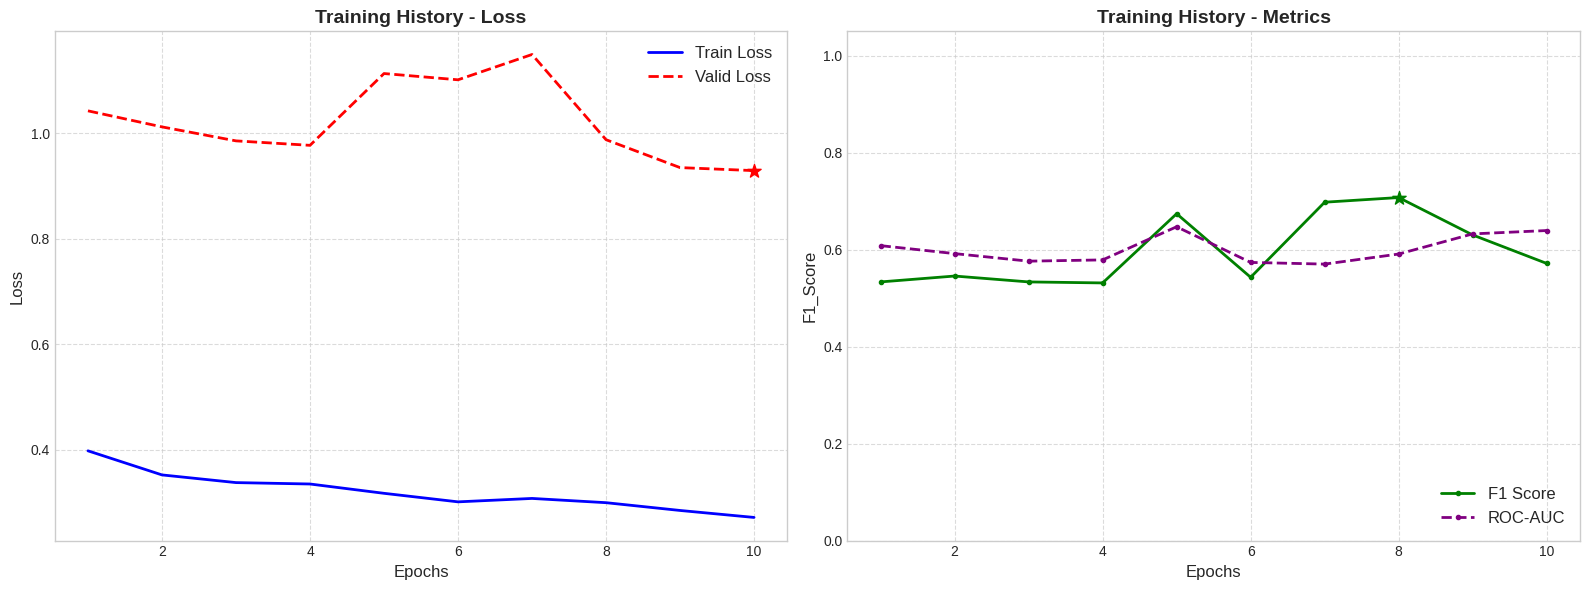

✅ Fold 1 Completed. F1 Score: 0.7073, AUC: 0.5908

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.699195,0.696129,0.500000,0.000000,0.000000,0.000000,0.698097,00:18
1,0.674737,0.655980,0.500000,0.000000,0.000000,0.000000,0.772491,00:18
2,0.665662,1.108307,0.500000,0.000000,0.000000,0.000000,0.635813,00:18


Better model found at epoch 0 with f1_score value: 0.0.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.666669,0.674942,0.500000,0.000000,0.000000,0.000000,0.696799,00:18
1,0.635197,0.828659,0.500000,0.000000,0.000000,0.000000,0.731834,00:19
2,0.623976,0.670545,0.500000,0.000000,0.000000,0.000000,0.801903,00:19
3,0.604723,0.576636,0.764706,0.705882,0.800000,0.750000,0.829585,00:18
4,0.550486,0.769432,0.544118,0.823529,0.528302,0.643678,0.723183,00:18
5,0.485537,1.079424,0.647059,0.352941,0.857143,0.500000,0.788927,00:18
6,0.444961,0.672586,0.735294,0.764706,0.722222,0.742857,0.793253,00:19
7,0.395105,0.741800,0.720588,0.617647,0.777778,0.688525,0.818339,00:18
8,0.350986,0.694290,0.735294,0.617647,0.807692,0.700000,0.810554,00:18
9,0.318412,0.675482,0.735294,0.647059,0.785714,0.709677,0.810554,00:18


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 3 with f1_score value: 0.7500000000000001.


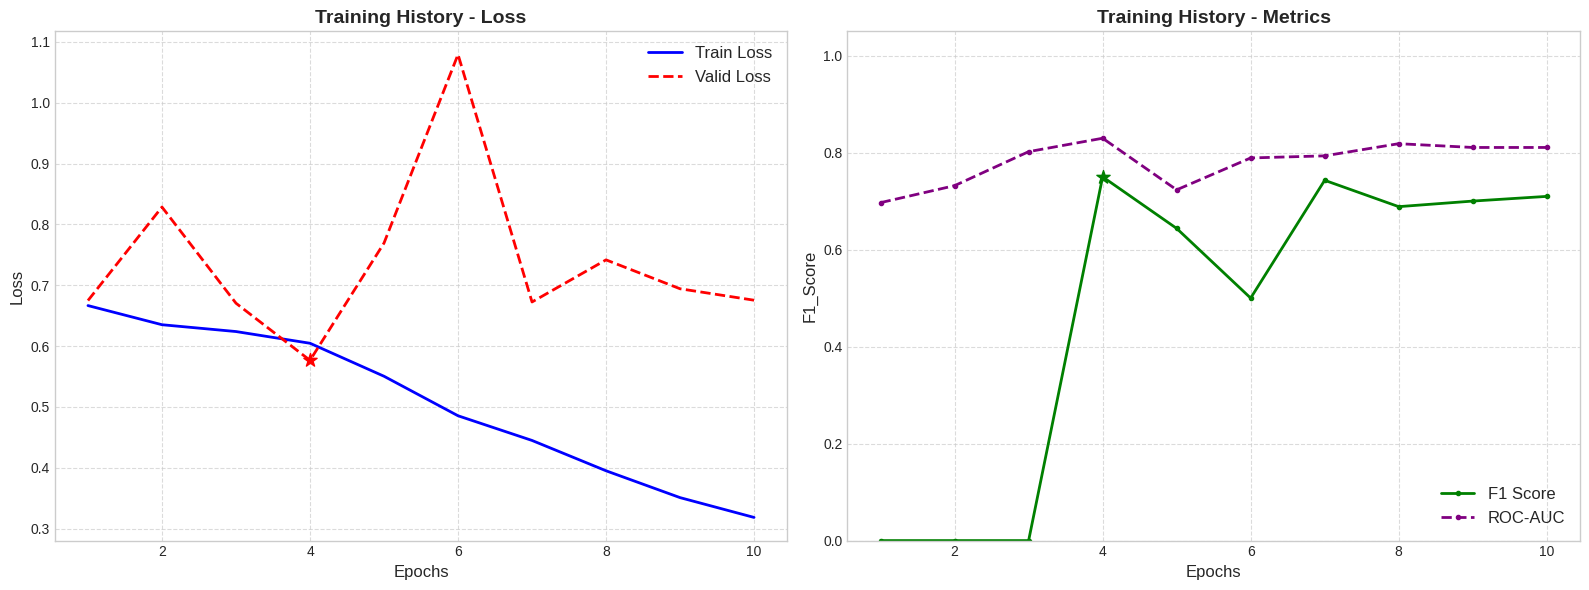

✅ Fold 2 Completed. F1 Score: 0.7500, AUC: 0.8296

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.695896,0.680964,0.500000,1.000000,0.500000,0.666667,0.926471,00:18
1,0.669091,0.609945,0.647059,0.970588,0.589286,0.733333,0.788062,00:17
2,0.659267,0.498831,0.852941,0.794118,0.900000,0.843750,0.931661,00:18


Better model found at epoch 0 with f1_score value: 0.6666666666666666.
Better model found at epoch 1 with f1_score value: 0.7333333333333333.
Better model found at epoch 2 with f1_score value: 0.84375.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.559903,0.456926,0.867647,0.823529,0.903226,0.861538,0.929066,00:18
1,0.499534,0.473030,0.852941,0.735294,0.961538,0.833333,0.932526,00:18
2,0.466749,0.727268,0.588235,0.882353,0.555556,0.681818,0.709343,00:18
3,0.449573,0.494684,0.838235,0.764706,0.896552,0.825397,0.881488,00:18
4,0.418260,0.589918,0.720588,0.882353,0.666667,0.759494,0.867647,00:17
5,0.372674,0.632054,0.750000,0.705882,0.774194,0.738462,0.829585,00:18
6,0.342715,0.521804,0.808824,0.705882,0.888889,0.786885,0.887543,00:17
7,0.315652,0.483278,0.838235,0.705882,0.960000,0.813559,0.909170,00:17
8,0.286314,0.461023,0.867647,0.794118,0.931034,0.857143,0.909170,00:18
9,0.271067,0.471853,0.838235,0.735294,0.925926,0.819672,0.910035,00:18


Better model found at epoch 0 with f1_score value: 0.8615384615384616.


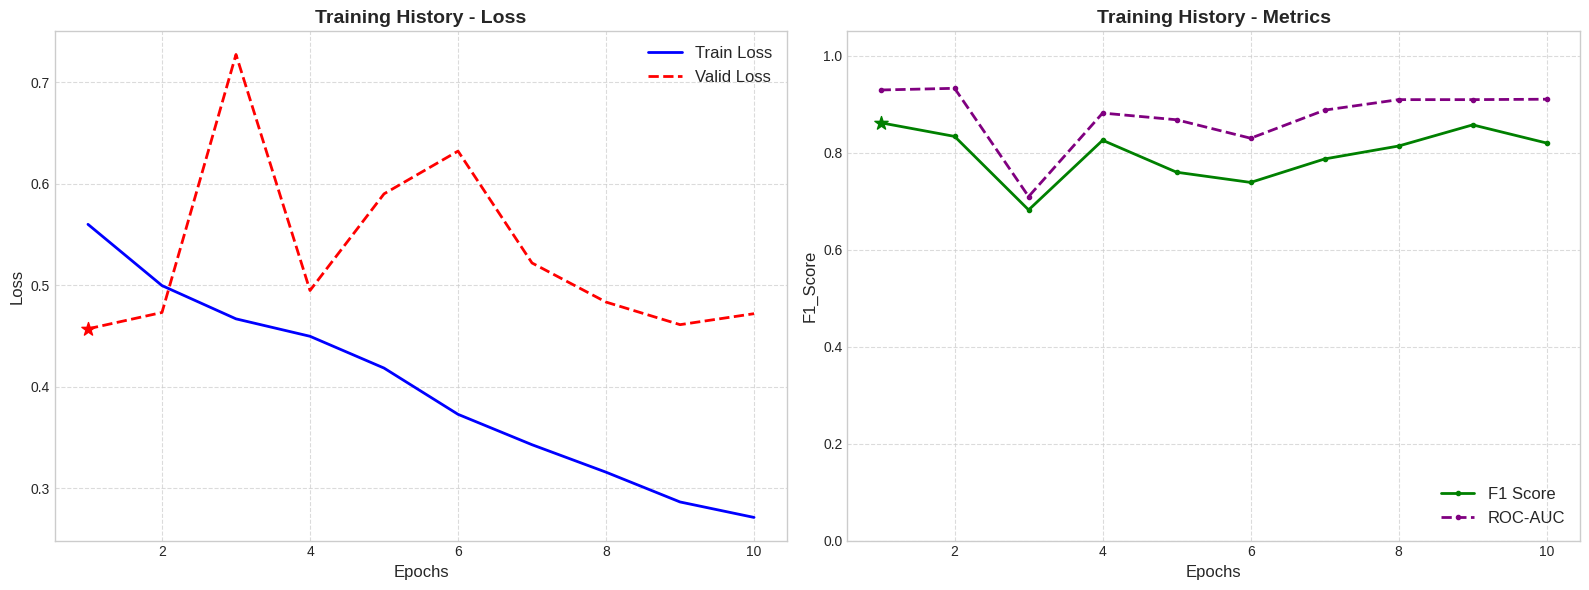

✅ Fold 3 Completed. F1 Score: 0.8615, AUC: 0.9291

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.689890,0.681878,0.686567,0.606061,0.714286,0.655738,0.732620,00:18
1,0.657695,0.565860,0.731343,0.818182,0.692308,0.750000,0.835116,00:18
2,0.616989,0.779541,0.686567,0.484848,0.800000,0.603774,0.776292,00:18


Better model found at epoch 0 with f1_score value: 0.6557377049180327.
Better model found at epoch 1 with f1_score value: 0.7500000000000001.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.466546,0.607062,0.761194,0.696970,0.793103,0.741935,0.861854,00:18
1,0.432289,0.456741,0.835821,0.727273,0.923077,0.813559,0.901961,00:17
2,0.402618,0.620881,0.776119,0.818182,0.750000,0.782609,0.847594,00:18
3,0.391849,0.599056,0.761194,0.787879,0.742857,0.764706,0.828877,00:18
4,0.375938,0.679546,0.731343,0.878788,0.674419,0.763158,0.859180,00:17
5,0.362626,0.670497,0.761194,0.545455,0.947368,0.692308,0.893939,00:17
6,0.346173,0.451058,0.805970,0.848485,0.777778,0.811594,0.923351,00:17
7,0.328694,0.486899,0.820895,0.696970,0.920000,0.793103,0.922460,00:17
8,0.301534,0.472009,0.835821,0.848485,0.823529,0.835821,0.914439,00:17
9,0.283737,0.484307,0.820895,0.848485,0.800000,0.823529,0.913547,00:17


Better model found at epoch 0 with f1_score value: 0.7419354838709677.
Better model found at epoch 1 with f1_score value: 0.8135593220338984.
Better model found at epoch 8 with f1_score value: 0.8358208955223881.


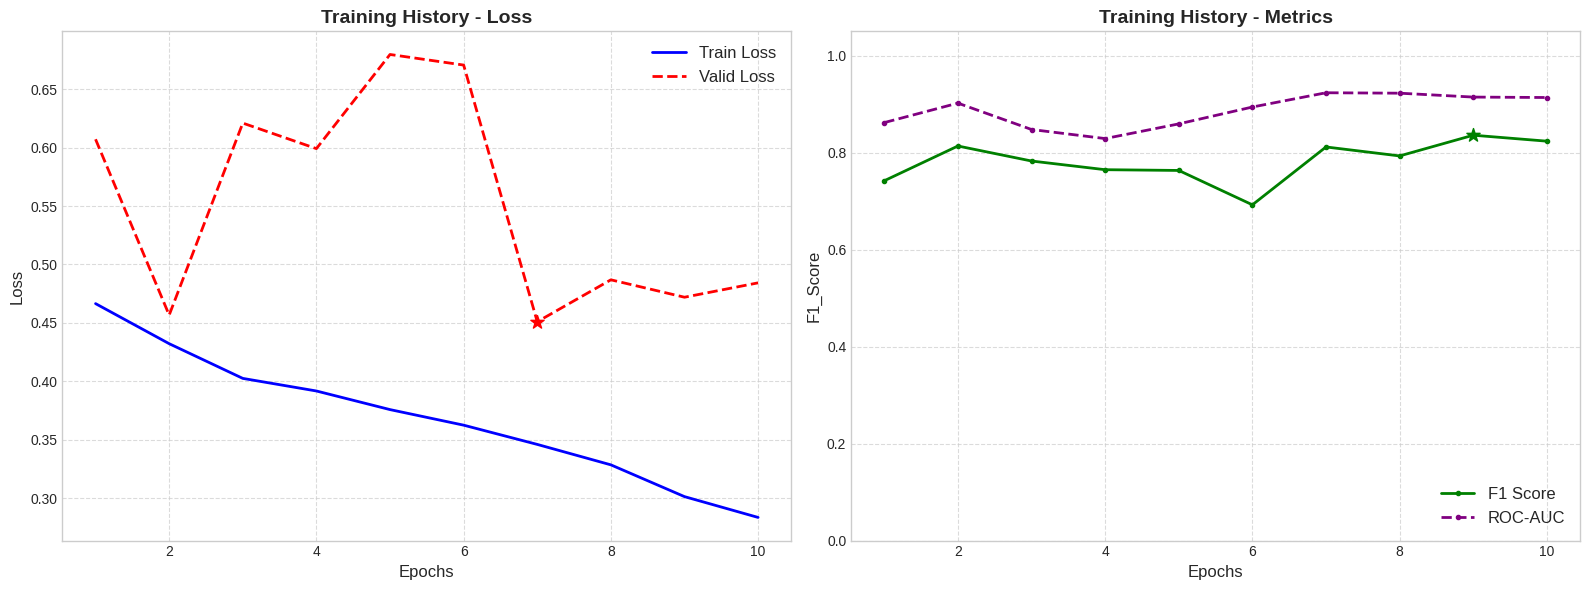

✅ Fold 4 Completed. F1 Score: 0.8358, AUC: 0.9144

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.704796,0.684928,0.492537,1.000000,0.492537,0.660000,0.805704,00:19
1,0.652549,0.903023,0.477612,0.757576,0.480769,0.588235,0.513369,00:17
2,0.647686,0.699237,0.522388,0.939394,0.508197,0.659574,0.685383,00:18


Better model found at epoch 0 with f1_score value: 0.66.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.646456,0.571104,0.835821,0.757576,0.892857,0.819672,0.885027,00:18
1,0.551316,0.604749,0.701493,0.515152,0.809524,0.629630,0.834225,00:18
2,0.505128,0.539265,0.761194,0.878788,0.707317,0.783784,0.865419,00:17
3,0.455591,0.701919,0.611940,0.939394,0.563636,0.704545,0.799465,00:17
4,0.416887,0.547138,0.761194,0.757576,0.757576,0.757576,0.847594,00:17
5,0.383422,0.522131,0.791045,0.787879,0.787879,0.787879,0.877897,00:17
6,0.354688,0.640100,0.716418,0.818182,0.675000,0.739726,0.852941,00:17
7,0.315009,0.572285,0.761194,0.878788,0.707317,0.783784,0.895722,00:18
8,0.291161,0.546829,0.761194,0.878788,0.707317,0.783784,0.895722,00:17
9,0.272425,0.531082,0.791045,0.848485,0.756757,0.800000,0.893939,00:18


Better model found at epoch 0 with f1_score value: 0.819672131147541.


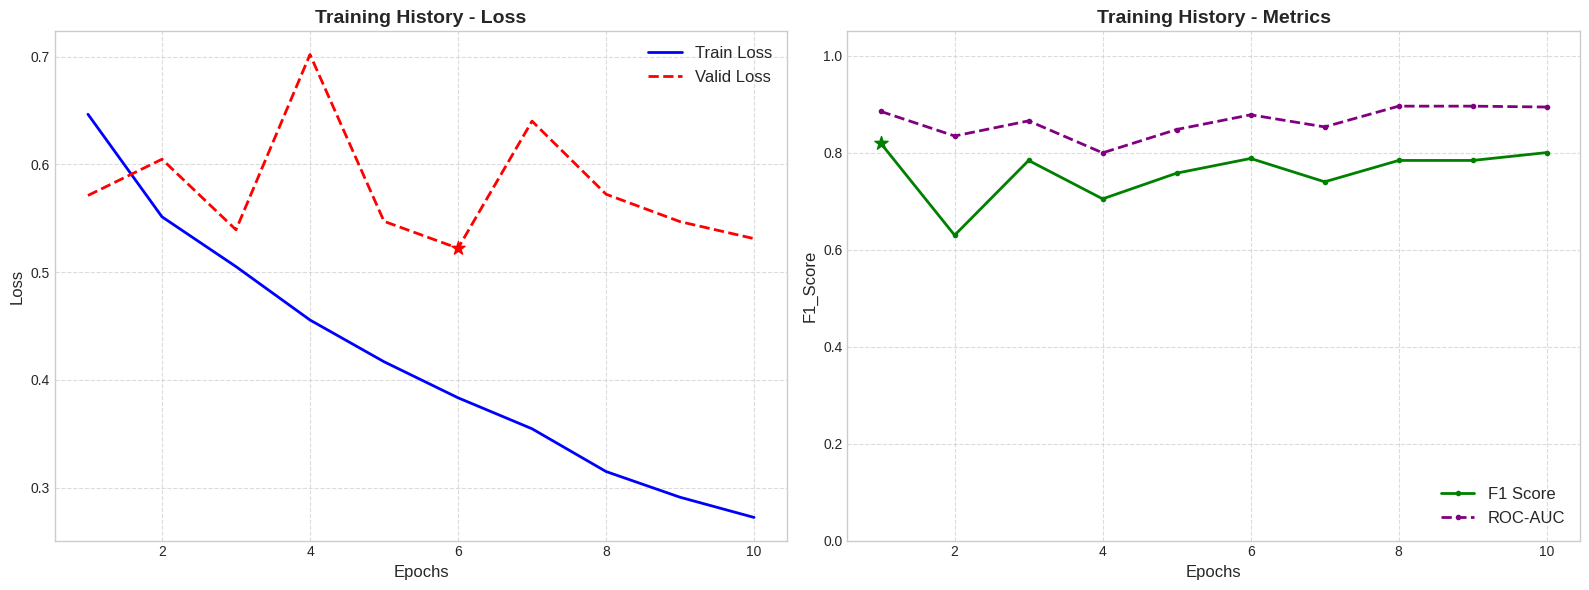

✅ Fold 5 Completed. F1 Score: 0.8197, AUC: 0.8850

--- K-Fold Evaluation ---
   Fold        F1       AUC
0     1  0.707317  0.590830
1     2  0.750000  0.829585
2     3  0.861538  0.929066
3     4  0.835821  0.914439
4     5  0.819672  0.885027
------------------------
Average F1 Score: 0.7949 ± 0.0641
Average AUC Score: 0.8298 ± 0.1389


In [27]:
print(f"\n--- Pretrained Model: MobileNet_v3 ---")

all_fold_metrics_mob = []
# Main loop
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)

    # Intialize the model
    torch.cuda.empty_cache()
    mobmodel = MobileModel()
    mobmodel = mobmodel.to("cuda:0")
    
    learner = Learner(dls, mobmodel, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'fold_{fold+1}_bst_mobilenet', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)

    # Train and save the best model
    learner.fine_tune(
        epochs=10,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold,"MobileNet_v3")

    # Validate and record results
    learner.load(f'fold_{fold+1}_bst_mobilenet') 
    metrics = learner.validate()

    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics_mob.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")
 
    
final_results_df = pd.DataFrame(all_fold_metrics_mob)
print("\n--- K-Fold Evaluation ---")
print(final_results_df)
print("------------------------")
print(f"Average F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"Average AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")